In [87]:
import numpy as np
from numpy import trapz

from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Урок 3.**<br>
<b>Домашнее задание:</b> Определите AUC_ROC и AUC_ROC для построенной модели на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.

## Классы и функции

In [88]:
def all_metrics_sklearn(y_true, y_predicted):
  print(f'Confusion matrix 0.5:\n{confusion_matrix(y_true, y_predicted)}\n')
  print(f'Precision_score: {precision_score(y_true, y_predicted)}\n')
  print(f'Recall_score: {recall_score(y_true, y_predicted)}\n')
  print(f'F1_score: {f1_score(y_true, y_predicted)}\n')
  print(f'ROC_AUC_score: {roc_auc_score(y_true, y_predicted)}')

In [89]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [90]:
class logistic:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @classmethod
    def log_loss(cls, w, X, y):
        m = X.shape[0]
        y=y[:, np.newaxis]
        # используем функцию сигмоиды, написанную ранее
        A = cls.sigmoid(np.dot(X, w.T))
        loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        grad = 1.0 / m * np.dot((A - y).T, X)
        return loss, grad
    @classmethod
    def optimize(cls, w, X, y, n_iterations, eta):
        #     потери будем записывать в список для отображения в виде графика
        losses = []
        for i in range(n_iterations):        
            loss, grad = cls.log_loss(w, X, y)
            w = w - eta * grad
            losses.append(loss)
        return w, losses
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=0.05
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        self.w, self.losses = self.optimize(w0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):
        y_predicted = np.zeros(X.shape[0])    
        return self.sigmoid(np.dot(X, self.w.T)).flatten()
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

## Генерация данных

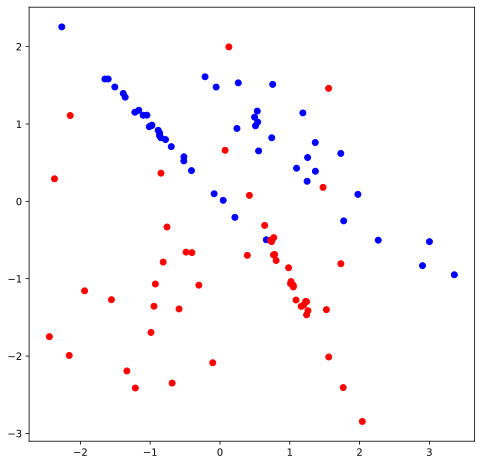

In [91]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=12)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

## Реализация логистической регрессии

In [92]:
# перемешивание датасета
np.random.seed(24)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [93]:
mod=logistic()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.8014639 2.6087803]]
Точность на обучающей выборке: 91.429
Точность на тестовой выборке: 90.000


## Матрица ошибок

In [94]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 11, 'FP': 2, 'FN': 1, 'TN': 16}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 8, 'FP': 1, 'FN': 4, 'TN': 17}


In [95]:
all_metrics_sklearn(y_test, mod.predict(X_test))

Confusion matrix 0.5:
[[16  2]
 [ 1 11]]

Precision_score: 0.8461538461538461

Recall_score: 0.9166666666666666

F1_score: 0.8799999999999999

ROC_AUC_score: 0.9027777777777777


## ROC-AUC

### Сначала посчитаем руками

In [96]:
y_pred_proba = mod.predict_proba(X_test)
np.sort(np.round(y_pred_proba, 5))  # Отсортируем предсказанные вероятности

array([0.00112, 0.00126, 0.00396, 0.00765, 0.01633, 0.01801, 0.06294,
       0.07344, 0.07908, 0.08087, 0.10887, 0.11398, 0.11445, 0.18973,
       0.24232, 0.31769, 0.353  , 0.539  , 0.54697, 0.63133, 0.74816,
       0.86042, 0.89197, 0.92606, 0.93423, 0.94289, 0.96217, 0.97834,
       0.98532, 0.99368])

In [97]:
# np.argsort отдаёт индексы для сортировки массива, как если бы мы использовали функцию sort()
# Т.е. я ниже правильные ответы сортирую также как и предсказания
y_test[np.argsort(np.round(y_pred_proba, 5))]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [98]:
# Длинный вариант по каждому наблюдению
TPR = [0, 0, 0.083333, 0.166666, 0.249999, 0.333332, 0.416665, 0.499998, 0.583331, 0.666664, 0.749997, 0.749997, 0.83333, 0.916663, 0.916663, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996, 0.999996]  # 1/12 ~ 0.083333
FPR = [0, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.055555, 0.11111, 0.11111, 0.11111, 0.166665, 0.166665, 0.22222, 0.277775, 0.33333, 0.388885, 0.44444, 0.499995, 0.55555, 0.611105, 0.66666, 0.722215, 0.77777, 0.833325, 0.88888, 0.944435, 0.99999]  # 1/18 ~ 0.055555

In [99]:
# Короткий вариант только по точкам изломов графика
TPR = [0, 0, 0.749997, 0.749997, 0.916663, 0.916663, 0.999996, 0.999996]  # 1/12 ~ 0.083333
FPR = [0, 0.055555, 0.055555, 0.11111, 0.11111, 0.166665, 0.166665, 0.99999]  # 1/18 ~ 0.055555

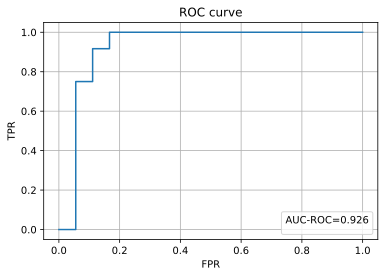

In [100]:
AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(-0.05, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

### Проверим расчеты готовыми библиотеками

In [119]:
y_pred_proba = mod.predict_proba(X_test)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

In [120]:
print(fpr)
print(tpr)
print(np.round(roc_thresholds, 2))

[0.         0.05555556 0.05555556 0.11111111 0.11111111 0.16666667
 0.16666667 1.        ]
[0.         0.         0.75       0.75       0.91666667 0.91666667
 1.         1.        ]
[1.99 0.99 0.75 0.63 0.54 0.35 0.32 0.  ]


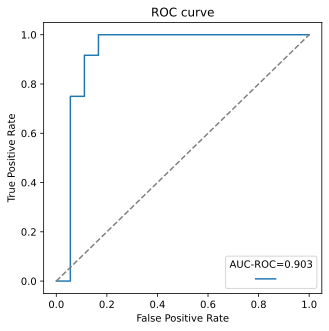

In [105]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(' ', title=f'AUC-ROC={roc_auc_score(y_test, mod.predict(X_test)):.3f}', loc='lower right')
plt.title('ROC curve')

plt.show()

Графики получились идентичныи, но общий ROC-AUC score немного отличается, что связываю с округлением в ручных рассчетах.

## PR curve

### Сначала посчитаем руками

In [105]:
'''precision = [0, 1, 0.5, 0.66, 0.75, 0.6, 0.5]
recall = [0, 0.33, 0.33, 0.66, 1, 1, 1]

AUC_PR = trapz(precision, x = recall, dx=0.1)

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall, precision)'''

### Проверим расчеты готовыми библиотеками

In [121]:
# calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, mod.predict(X_test))

In [122]:
print(precision)
print(recall)
print(pr_thresholds)

[0.4        0.84615385 1.        ]
[1.         0.91666667 0.        ]
[False  True]


In [123]:
# calculate F1 score
f1 = f1_score(y_test, mod.predict(X_test))

In [124]:
# calculate precision-recall AUC
pr_auc = auc(recall, precision)

Logistic: f1=0.880 pr_auc=0.898


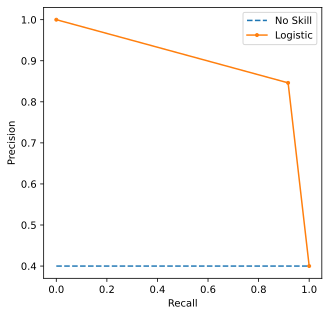

In [125]:
# summarize scores
print('Logistic: f1=%.3f pr_auc=%.3f' % (f1, pr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()